In [1]:
import keras
import tensorflow as tf
import pandas as pd
import os

from os import path
from keras.utils import image_dataset_from_directory
from matplotlib import pyplot as plt
from keras import layers, losses, optimizers, metrics

In [2]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [3]:
SEED = 123
N_CLASS = 10

In [4]:
labels_df = pd.read_csv(path.join(os.getcwd(), 'cifar-10', 'trainLabels.csv'))
labels_df.label = pd.Categorical(labels_df.label)
labels_df['codes'] = labels_df.label.cat.codes

dataset_train, dataset_val = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'cifar-10', 'train'),
    labels=list(labels_df['codes']),
    label_mode='int',
    validation_split=0.3,
    shuffle=False,
    subset='both',
    image_size=(32,32),
    batch_size=64,
    seed=SEED
)
dataset_train = dataset_train.map(lambda x, y : (x / 255.0, tf.one_hot(y, N_CLASS)))
dataset_val = dataset_val.map(lambda x, y : (x / 255.0, tf.one_hot(y, N_CLASS)))

Found 50000 files belonging to 1 classes.
Using 35000 files for training.
Using 15000 files for validation.


In [5]:
X, y = next(iter(dataset_train))

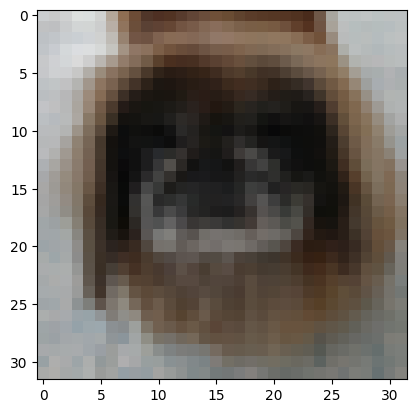

In [6]:
plt.imshow(X[3].numpy())

In [7]:
y[3]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)>

## Simple keras sequential model

In [20]:
model = keras.Sequential()

model.add(keras.Input(shape=(32, 32, 3)))

model.add(layers.Conv2D(32, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
model.add(layers.Conv2D(32, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
model.add(layers.Conv2D(64, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
model.add(layers.MaxPooling2D(2))

# Fully connected classifier
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(N_CLASS, activation="softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

In [21]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)

In [23]:
X.numpy()

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

In [22]:
history = model.fit(
    dataset_train,
    epochs=25,
    workers=2,
    use_multiprocessing=True,
    validation_data=dataset_val,
    shuffle=True
)

Epoch 1/10
547/547 [==============================] - 90s 162ms/step - loss: 2.3122 - categorical_accuracy: 0.0971 - val_loss: 2.3034 - val_categorical_accuracy: 0.0984
Epoch 2/10
547/547 [==============================] - 86s 157ms/step - loss: 2.3037 - categorical_accuracy: 0.0970 - val_loss: 2.3034 - val_categorical_accuracy: 0.0984
Epoch 3/10
547/547 [==============================] - 89s 163ms/step - loss: 2.3037 - categorical_accuracy: 0.0968 - val_loss: 2.3034 - val_categorical_accuracy: 0.0984
Epoch 4/10
547/547 [==============================] - 92s 168ms/step - loss: 2.3037 - categorical_accuracy: 0.0968 - val_loss: 2.3034 - val_categorical_accuracy: 0.0984
Epoch 5/10
163/547 [=======>......................] - ETA: 54s - loss: 2.3032 - categorical_accuracy: 0.0978

KeyboardInterrupt: 

In [ ]:
history